### 图像分类数据集
MNIST 数据集是图像分类中广泛使用的数据集之一，但作为基准数据集来说过于简单。我们将使用类似但更复杂的Fashion-MNIST数据集

In [1]:
%matplotlib inline 
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### 通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
# 除以255进行归一化
trans = transforms.ToTensor()#就是使用TOTensor进行转换
#train=True 下载的是训练数据集trans 表示拿到的是tensor而非一系列图片 download=True 从网上下载
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True,
                                                transform=trans, download=True)
#测试数据集
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False,
                                                transform=trans, download=True)


In [3]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

两个可视化数据集的函数

In [4]:
def get_fashion_mnist_labels(labels):
    """"返回fashion-MNIST数据集的文本标签"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker',
        'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    # 这里的_表示忽略我们不使用的变量
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img, lbl) in enumerate(zip(axes, imgs, titles)):
        ax.set_title(lbl)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        


### 几个样本的图像及其相应的标签

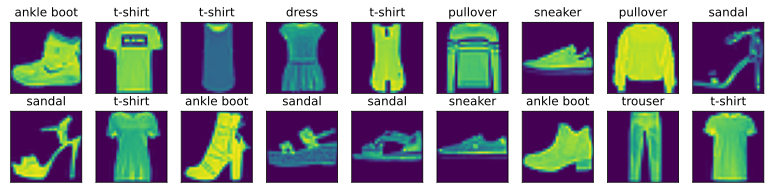

In [5]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

### 读取一小批量数据，大小为batch_size

In [6]:
batch_size = 256

def get_dataloader_workers():
    '''使用4个进程读取数据'''
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'1.59 sec'

### 定义load_data_fashion_mnist函数

In [7]:
def load_data_fashion_mnist(bacth_size, resize=None):
    """download the dataset of Fashion_MNIST, then load it to the memory"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()))

### softmax regression and start it from the very beginning 

In [8]:
import torch
from IPython import display
from d2l import torch as d2l
from torch import nn

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### flatten each image and see it as a vector of 784 dimension(28*28). Since there are 10 pieces, defining the output as 10 dimension

In [32]:
num_inputs = 784
num_outputs = 10

num_inputs, num_outputs, num_hiddens = 784, 10,256
W1 = nn.Parameter(
    torch.randn(num_inputs, num_hiddens, requires_grad=True))
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(
    torch.randn(num_hiddens, num_outputs, requires_grad=True))
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

### giving a matrix X, to calculate the sum of all elementaries

In [10]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

### to realize the softmax
$$softmax(X)_{ij}=\frac{\exp{X_{ij}}}{\sum_k{\exp{X_{ik}}}}$$

In [11]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # we use the mechanism of propagation there.

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    #the shape is the same as X, but the value of all elemenatry is zeros
    return torch.max(X, a)

### to realize the model of softmax

In [13]:
def net(X):
    X = X.reshape((-1, num_inputs))
    #to flattern the 28*28 matrix to 784 vector
    H = relu(X @ W1 + b1)
    # @ is the inner multiply
    return (H @ W2 + b2)

### to create a data y_hat, including the probabilities of the 2 samples in these 3 pieces, and using y ad the index of the probability of y_hat.

In [14]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

### to realize the cross entropy loss function

In [47]:
"""def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])"""
loss = nn.CrossEntropyLoss()

#cross_entropy(y_hat, y)

### by comparing the prediction with the true y to get the accuracy
 

In [16]:
def accuracy(y_hat, y):
    ''''calculate the number of the true prediction'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        #find maximum of each columns
    cmp = y_hat.type(y.dtype) == y
    #compare the y_hat with y, then get the bool value as the times of correct predictions.
    return float(cmp.type(y.dtype).sum()) # return times

accuracy(y_hat, y) / len(y)
#why we need divide the len(y)? In fact, when the last bacth_size has not enough data, 
#we will need the len(y) to ensure our result to be true.

0.5

### we can evaluate the accuracy of any net model

In [17]:
def evaluate_accuracy(net, data_iter):
    """calculate the accuracy of the designated dataset"""
    if isinstance(net, torch.nn.Module):
        net.eval() #set the model evaluation mode
    metric = Accumulator(2) # correct number and total quantity of the prediction
    #Accumulator(2) create a list 
    for X, y in data_iter:
        # get a batch_size in dataset
        metric.add(accuracy(net(X), y), y.numel())
        #because this is a list with len 2, so we need two parameters in add? 
    return metric[0] / metric[1]
# I guess in this function, it calculate the total predicted accuracy and total true accuracy.
#but the true accuracy is 1 ?

### In Accumulator, we create two varible, to storage predicted correct quantity and summation respectively

In [18]:
class Accumulator:
    """accumulate on the n varibles"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)#does this mean that to reset all the elementory in self.data to 0?
    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)
#be careful that do not make mistakes about the name writing when you define this



0.085

In [49]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # if the optimizer is belong to the torch
            updater.zero_grad()
            #torch will not reset the grad if you are in a loop, so you need the function of reset
            #u = l.sum()
            l.sum().backward()
            #calculate the gradient
            updater.step()
            #upload the parameter
            metric.add(
                float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            l.backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
            #return the amount of the elementary in tuple y
    return metric[0] / metric[2], metric[1] / metric[2]


### define a practical class used to portray the data trendancy in animation

In [20]:
# this function used to plot is really difficult for me.
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g--', 'r--'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes, = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]#there is an extra comma
            #use lambda function to capture the parameters
            self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
            self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]#how does this phrase work
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a  is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### training function

In [34]:
def train_ch3(net, train_iter, test_iter, loss, num_epoches, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epoches], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epoches):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics 

### loss used to optimize the model with small batch_size random gradient descent

In [22]:
num_epoches, lr = 10, 0.1 
updater = torch.optim.SGD(params, lr=lr)

### train the model in ten epoches

KeyboardInterrupt: 

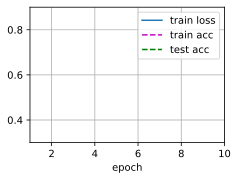

In [50]:

train_ch3(net, train_iter, test_iter, loss, num_epoches, updater)

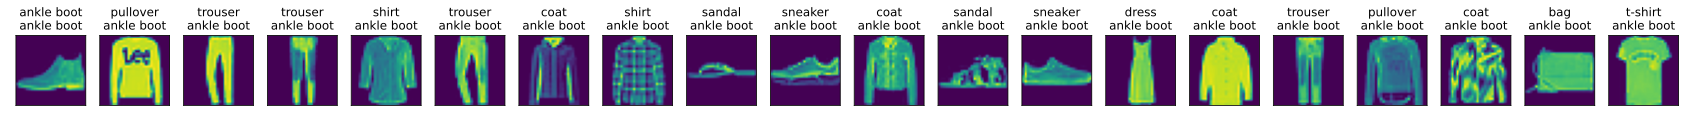

In [31]:
def predict_ch3(net, test_iter, n=20):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)